In [1]:
import pandas as pd
import json
import numpy as np , re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets , sys
from sklearn.preprocessing import MinMaxScaler
sys.path.append('/home/advice/Python/SR/Custom/')
from jupyter_tensorboard import *
from utility import *
from Init import *
from Activations import *
from wasserstein import Wasserstein
from IPython.display import clear_output
import os , re
import collections
from collections import Counter
import warnings


    사용하면 좋은 패키지
    train_validation_test_split / cat2dict / code2cat / colorlist / onehotencoding / roccurve  / ProbDensity
    pycm import *  
    ConfusionMatrix(actual_vector=``test_y``, predict_vector= ``pred`` ) 
    사용하면 통계량값 다 얻을 수 있음
    


In [2]:
#pd.read_json("./Cloth/modcloth_final_data.json" , orient='columns')
# mc_df = pd.read_json('./Cloth/modcloth_final_data.json', lines=True)
# mc_df.isna().sum()
# mc_df.head()

In [3]:
rtr_df = pd.read_json('./Cloth/renttherunway_final_data.json', lines=True)

In [4]:
rtr_df.shape

(192544, 15)

In [5]:
import pandas_profiling
if os.path.isfile("Cloth_profiling.html")  :
    print("Profiling 존재")
    pass
else :
    profile = rtr_df.profile_report(title='Girl Cloth Profiling Report')
    profile.to_file(output_file="Cloth_profiling.html")

Profiling 존재


In [6]:
rtr_df.isna().sum()

fit                   0
user_id               0
bust size         18411
item_id               0
weight            29982
rating               82
rented for           10
review_text           0
body type         14637
review_summary        0
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64

In [7]:
rtr_df["size"]

0         14
1         12
2          4
3          8
4         12
          ..
192539     8
192540     4
192541     8
192542    16
192543    16
Name: size, Length: 192544, dtype: int64

In [8]:
rtr_df.height

0         5' 8"
1         5' 6"
2         5' 4"
3         5' 5"
4         5' 9"
          ...  
192539    5' 9"
192540    5' 1"
192541    5' 8"
192542    5' 6"
192543    5' 6"
Name: height, Length: 192544, dtype: object

In [9]:
id_weight = rtr_df[["user_id", "weight"]].groupby("user_id").agg({"weight" : np.unique})
d = id_weight.reset_index()["weight"]

In [10]:
store = []
for idx , i in enumerate(d.values.tolist()) :
    try :
        if re.search("lbs" , i) is not None :
            pass
        else :
            store.append(idx)
    except Exception as e :
        store.append(idx)
len(store)

18271

In [11]:
d[store].astype(str).value_counts().iloc[0:10]

nan                                          13227
[nan nan]                                     2926
[nan nan nan]                                  999
[nan nan nan nan]                              433
[nan nan nan nan nan]                          231
[nan nan nan nan nan nan]                      128
[nan nan nan nan nan nan nan]                   89
[nan nan nan nan nan nan nan nan]               55
[nan nan nan nan nan nan nan nan nan]           38
[nan nan nan nan nan nan nan nan nan nan]       28
Name: weight, dtype: int64

## 전처리 (height , weight)

In [12]:
def weight_preprocessing(data) :
    data["weight"] = \
    data["weight"].map(lambda x : float(re.sub('lbs', '' , x )) * 0.453592)
    return data

def height_preprocessing(data) :
    data["height"] = \
    data["height"].map(lambda x : round( 2.54 * (float(re.sub(r'[^A-Za-z0-9]+', ' ' , x ).split(" ")[0])*12 + float(re.sub(r'[^A-Za-z0-9]+', ' ' , x ).split(" ")[1])  ) , 1 ))
    return data

def Weight_Height_Preprocessing(f , data , col ) :
    T_F = data[col].isna()
    not_na = data[~T_F]
    na = data[T_F]
    not_na2 = f(not_na)
    newdata = not_na2.groupby(['size','fit',"category"], group_keys=False).\
    apply(lambda x: x[col].mean() ).reset_index()
    newdata.columns = newdata.columns.tolist()[:3] + [col]
    na2 = pd.merge( na.drop([col],axis = 1) , newdata ,  how = "left")
    na3 = na2[not_na2.columns]
    na3[col].fillna((na3[col].mean()), inplace=True)
    final = pd.concat([not_na2 , na3 ] , axis = 0)
    return final

In [13]:
rtr_df2 = rtr_df.copy()

In [14]:
rtr_df2 = Weight_Height_Preprocessing(weight_preprocessing , rtr_df2 , "weight")
rtr_df2 = Weight_Height_Preprocessing(height_preprocessing , rtr_df2 , "height")

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/root/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [15]:
rtr_df2[["height", "weight"]].isna().sum()

height    0
weight    0
dtype: int64

```
rtr_df["weight"] = \
rtr_df["weight"].map(lambda x : float(re.sub('lbs', '' , x )) * 0.453592)
rtr_df["height"] = \
rtr_df["height"].map(lambda x : round( 2.54 * (float(re.sub(r'[^A-Za-z0-9]+', ' ' , x ).split(" ")[0])*12 + float(re.sub(r'[^A-Za-z0-9]+', ' ' , x ).split(" ")[1])  ) , 1 ))
```

In [16]:
rtr_df2.head(3)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,62.142104,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,172.7,14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,59.874144,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,167.6,12,36.0,"June 18, 2013"
3,fit,909926,34c,126335,61.234920,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,165.1,8,34.0,"February 12, 2014"


In [17]:
rtr_df2.isna().sum()

fit                   0
user_id               0
bust size         18411
item_id               0
weight                0
rating               82
rented for           10
review_text           0
body type         14637
review_summary        0
category              0
height                0
size                  0
age                 960
review_date           0
dtype: int64

In [18]:
rtr_df2["body type"].fillna("Secret" , inplace = True)
rtr_df2["bust size"].fillna("Secret" , inplace = True)
rtr_df2["rented for"].fillna("Secret" , inplace = True)

In [19]:
rtr_df2.isna().sum()

fit                 0
user_id             0
bust size           0
item_id             0
weight              0
rating             82
rented for          0
review_text         0
body type           0
review_summary      0
category            0
height              0
size                0
age               960
review_date         0
dtype: int64

## rating 같은 경우에는 review_summary를 확인을 해서 좋은 감정 표현이 있으면 점수를 높게주고, 아니면 낮게주는 방식으로 할 수 있지만, 귀찮음

In [20]:
rtr_df2.dropna(subset = ["rating"], axis = 0 , inplace = True)

In [21]:
rtr_df2.isna().sum()

fit                 0
user_id             0
bust size           0
item_id             0
weight              0
rating              0
rented for          0
review_text         0
body type           0
review_summary      0
category            0
height              0
size                0
age               959
review_date         0
dtype: int64

## age 같은 경우에 이상한 결측치가 많음

> 0살? 120살?

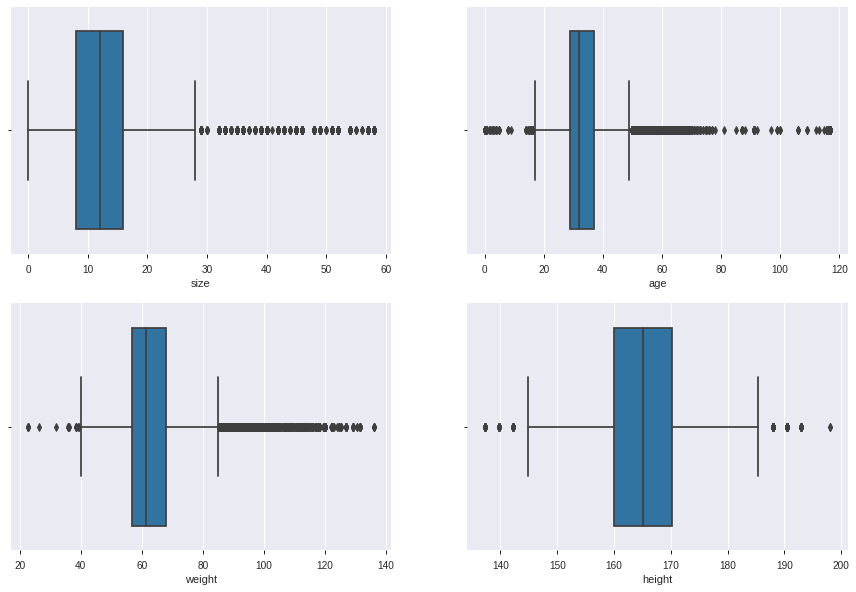

In [22]:
numeric_type = ["size", "age" , "weight", "height"]
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for var, subplot in zip(numeric_type, ax.flatten()):
    sns.boxplot( x = var , data=rtr_df2 ,ax=subplot)

In [23]:
detect = (rtr_df2["age"] < 10) | (rtr_df2["age"] > 90)
strange_age = rtr_df2[detect].age.values.tolist()
mean_age = int(rtr_df2[~detect]["age"].mean())
rtr_df2.age.replace(strange_age , mean_age , inplace = True )

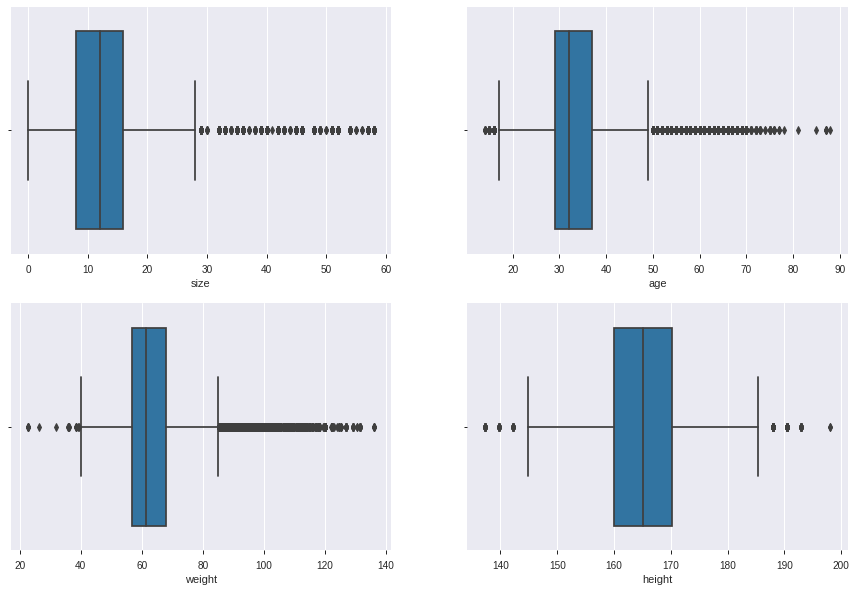

In [24]:
numeric_type = ["size", "age" , "weight", "height"]
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for var, subplot in zip(numeric_type, ax.flatten()):
    sns.boxplot( x = var , data=rtr_df2 ,ax=subplot)

In [25]:
min_max_age = rtr_df2.age.describe()[["min" , "max"]].values
bucket = [min(min_max_age) , 20 , 24, 29 , 32 , 35 , 38, 44 , 60 , max(min_max_age)]
age = pd.cut(rtr_df2["age"], bucket , labels = ["14~20" , "21~24" , "25~29"  , "30~32"  , "33~35" ,
                                                "36~38" , "39~44" , "45~60" , "61~88" ])
age = age.cat.add_categories("Secret").fillna("Secret")
rtr_df2["age"] = age

In [26]:
rtr_df2.isna().sum()

fit               0
user_id           0
bust size         0
item_id           0
weight            0
rating            0
rented for        0
review_text       0
body type         0
review_summary    0
category          0
height            0
size              0
age               0
review_date       0
dtype: int64

In [27]:
rtr_df = rtr_df2.copy()

In [28]:
target = rtr_df["item_id"]
#data = rtr_df.drop(["item_id"],axis = 1)
target =target.apply(lambda x : "Item_" + str(x))
rtr_df["item_id"] = target
target = pd.get_dummies(target)
data = rtr_df

In [29]:
data["month"] , data["day"] , data["year"]= zip(*data["review_date"].apply(lambda x : x.split()))
data["day"] = data["day"].apply(lambda x : int(re.sub(",", "" , x)))

In [30]:
data.drop(["review_date"], axis =1 , inplace = True)

In [73]:
 X_train , X_test , y_train, y_test = train_test_split(
        data, target , test_size=int(rtr_df.shape[0] * 0.3), random_state=1234, 
     shuffle=True)

In [74]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((134724, 17), (57738, 17), (134724, 5850), (57738, 5850))

In [75]:
X_train.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,month,day,year
101158,fit,141730,36c,Item_1036192,77.11064,8.0,party,The seem line around the upper belly area is s...,pear,The dress was comfortable and amazing. The lac...,dress,177.8,24,33~35,May,10,2017
170583,large,399803,34c,Item_183194,56.69900,6.0,wedding,"I got this dress in the mail, and couldn't wai...",hourglass,"Comfortable, flowy, pretty dress, but man was ...",dress,157.5,8,25~29,June,10,2014
179152,fit,840452,36b,Item_265806,77.11064,10.0,everyday,"Fitted up top, which was perfect for me (no ne...",pear,Long length is great for the tall ladies.,maxi,177.8,16,25~29,June,15,2016
84077,fit,865094,34b,Item_145906,63.50288,8.0,wedding,It fit great and was very flattering,pear,I got so many compliments on this dress!,gown,157.5,12,30~32,August,14,2014
101461,fit,149629,32b,Item_187164,54.43104,10.0,party,Loved this dress! This is my favorite Herve I ...,hourglass,LOVE!,dress,162.6,4,30~32,August,21,2012


In [48]:
X_train.groupby(["fit" , "rented for"]).agg({"rating" : "mean" }).reset_index().head()

,fit,rented for,rating
0,fit,Secret,8.571429
1,fit,date,9.216871
2,fit,everyday,9.133858
3,fit,formal affair,9.397632
4,fit,other,9.320281


In [50]:
X_train["item_id"].value_counts().head(10)

Item_126335    1596
Item_123793    1212
Item_174086    1209
Item_132738    1097
Item_145906    1057
Item_127865     965
Item_136110     847
Item_131533     748
Item_137585     741
Item_172027     707
Name: item_id, dtype: int64

In [ ]:
X_train["user_id"].value_counts().head()

In [39]:
X_train.groupby(["category", "item_id"]).count()["user_id"].reset_index().shape

(5701, 3)

In [52]:
X_train["age"]  = X_train.age.astype(str)

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
X_train[["month" ,"item_id" , "age"]].iloc[1]

month             June
item_id    Item_183194
age              25~29
Name: 170583, dtype: object

## doc2vec을 어떻게 활용할 수 있을까? (아이템을 묶긴 해야함)

* 글자와 구매 상품을 묶으면 합리적일까?
* 글자와 구매 상품 그리고 카테고리를 묶으면 효과적일까? <br>
**리뷰의 평가와 가장 연관이 있는 것은 무엇일까?**
* 개인적인 생각으로는 **fit** 이 제일 영향을 줄 것 같다. 
* 리뷰를 적을 때 fit 정도에 따라서 작다 크다 이런 표현을 쓸 것 같다. 하지만 이건 너무 상대적인 개념이기 때문에 같은 제품에 여러 fit이 나오는데 자기 체형하고 연관되어있기 때문에 부적절한거 같다.
* Review ~ (item + age bucket)
    * 왠만하면 나이에 따라 유행하는 옷이 다를 것이니 같이 고려하면 좋을 것 같다

In [ ]:
var = ["review_text", "review_summary" , ]
tag = ["item_id" , "age"]
train_docs = [(" ".join(row[ var ]) , 
               str(row['year']) + "/" + row['item_id']+ "/" +row["age"]) for idx, row in X_train.iterrows()]
test_docs = [(" ".join(row[ var ]) , 
              str(row['year'])+ "/" + row['item_id']+ "/" +row["age"]) for idx, row in X_test.iterrows()]

In [ ]:
X_train.drop(var , axis = 1 , inplace = True)
X_test.drop(var , axis = 1 , inplace = True )

In [ ]:
X_train.head()

In [58]:
X_train.to_csv( "Cloth_TRAIN.csv" , index = False )
X_test.to_csv( "Cloth_TEST.csv" , index = False )

In [59]:
from IPython.display import Image
from multiprocessing import Pool
from gensim.models import doc2vec
from collections import namedtuple
import multiprocessing

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [ ]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags')
def TagDoc(data) :
    import string
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer
    porter = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    stop_words2 = stop_words | {""}
    tagged_train_docs = []
    for d , c in data :
        tokens = word_tokenize(d.lower())
        table = str.maketrans('', '', string.punctuation)
        words = [w.translate(table) for w in tokens]
        words = [w for w in words if not w in stop_words2 ]
        words = [porter.stem(word) for word in words]
        Tag_Doc = TaggedDocument(words , [c]) 
        tagged_train_docs.append(Tag_Doc)
    return tagged_train_docs

In [ ]:
tagged_test_docs = TagDoc(test_docs)
tagged_train_docs = TagDoc(train_docs)

In [ ]:
# for i in df.columns[1:]:
#     df['{}1'.format(i)], df['{}2'.format(i)] = zip(*df[i].apply(lambda x: list(x)))

import pickle
with open("Tagged_Train_Docs.p" , "wb") as p :
    pickle.dump(tagged_train_docs , p)
with open("Tagged_Test_Docs.p" , "wb") as p :
    pickle.dump(tagged_test_docs , p)

In [ ]:
if True:
    doc_vectorizer = doc2vec.Doc2Vec(
    dm = 1,            # PV-DM
    dbow_words = 1,    # w2v simultaneous with DBOW d2v / default 0
    window = 8,        # distance between the predicted word and context words 
    size = 300,        # vector size 
    sample = 1e-5,     # threshold for configuring
    min_count = 3,     # ignore with freq lower
    negative = 10,     # negative sampling / default 5
    seed = 2019,
    workers = 30,       # single cpu -> reproducible 
    alpha = 0.05,      # learning-rate
    min_alpha = 0.05   # min learning-rate

    )
    
    doc_vectorizer.build_vocab(tagged_train_docs)
    print(str(doc_vectorizer))
    
    for epoch in range(50):
        print(epoch)
        doc_vectorizer.train(tagged_train_docs, epochs = doc_vectorizer.iter ,
                             total_examples = doc_vectorizer.corpus_count )
        doc_vectorizer.alpha -= 0.002
        doc_vectorizer.min_alpha = doc_vectorizer.alpha
    
    print("Doc2Vec 학습 완료.")
# To save

In [84]:
doc_vectorizer.save('./Cloth_User2Vec.model')

In [85]:
print("Load")
doc_vectorizer=doc2vec.Doc2Vec.load('./Cloth_User2Vec.model')

Load


In [86]:
train_item = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
test_item = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]

In [87]:
train_item_pd = pd.DataFrame(train_item)
test_item_pd = pd.DataFrame(test_item)
train_item_pd.columns = ["Item_Age_" + str(i) for i in train_item_pd.columns.tolist()]
test_item_pd.columns = ["Item_Age_" + str(i) for i in test_item_pd.columns.tolist()]

In [89]:
train_item_pd.head()

,Item_Age_0,Item_Age_1,Item_Age_2,Item_Age_3,Item_Age_4,Item_Age_5,Item_Age_6,Item_Age_7,Item_Age_8,Item_Age_9,...,Item_Age_290,Item_Age_291,Item_Age_292,Item_Age_293,Item_Age_294,Item_Age_295,Item_Age_296,Item_Age_297,Item_Age_298,Item_Age_299
0,0.033927,0.030585,-0.025080,-0.054029,-0.041128,-0.000305,-0.008617,0.039155,-0.026958,-0.079836,...,-0.013011,0.012371,-0.007729,0.003361,0.035664,-0.070409,-0.006274,-0.025972,-0.020863,-0.044886
1,-0.000934,-0.000994,0.000816,0.001080,-0.000562,0.000373,0.000708,-0.001435,-0.000469,-0.001134,...,-0.000091,0.001158,-0.001262,0.001336,-0.000700,0.001566,0.001626,-0.001288,-0.001555,-0.000459
2,-0.005453,-0.014091,0.002323,0.015815,0.008671,-0.001880,0.001726,-0.009988,0.005885,0.013818,...,-0.001604,0.003766,0.002093,-0.001674,-0.002020,0.008864,0.003061,0.002652,-0.002859,0.010739
3,0.001590,0.001079,-0.001556,0.000281,-0.000919,0.000312,0.001131,-0.000905,-0.000436,0.000442,...,0.000198,0.000354,0.000941,-0.001159,0.000862,-0.000538,0.000748,-0.001463,-0.001147,0.001416
4,-0.001656,0.000128,0.000513,0.000662,-0.000692,0.001134,0.000203,-0.000086,0.000971,0.000367,...,-0.001176,0.001601,0.000222,0.001241,-0.001555,0.000416,0.001064,-0.000295,-0.000734,-0.001562


In [270]:
X_train = pd.read_csv( "Cloth_TRAIN.csv"  )
X_test = pd.read_csv( "Cloth_TEST.csv" )

In [271]:
X_train.shape , X_test.shape

((134724, 15), (57738, 15))

## **category** 변수

```
tr_Segment = X_train["category"]
te_Segment = X_test["category"]
X_train.drop(["category"] , axis = 1 , inplace = True)
X_test.drop(["category"] , axis = 1 , inplace = True)
print(tr_Segment.shape , te_Segment.shape)
X_train[X_train.user_id == 691468].sort_values(["year", "month" , "day"]).head()
Total_Seg = list(set(tr_Segment.values.tolist()) | set(te_Segment.values.tolist() ))
print(Total_Seg)
assert len(Total_Seg) == len( np.unique(Total_Seg))
Seg_dummy = pd.get_dummies(pd.concat([tr_Segment , te_Segment ], axis = 0))
print(Seg_dummy.shape)
tr_Seg_dummy = Seg_dummy.iloc[ :tr_Segment.shape[0] , :]
te_Seg_dummy = Seg_dummy.iloc[tr_Segment.shape[0] : , :]
print(tr_Seg_dummy.shape , te_Seg_dummy.shape)
tr_Seg_dummy.head()
```

## rented for 도 Segment 역할을 기대할 수 있음.

```
tr_Rent_Segment = X_train["rented for"]
te_Rent_Segment = X_test["rented for"]
X_train.drop(["rented for"] , axis = 1 , inplace = True)
X_test.drop(["rented for"] , axis = 1 , inplace = True)
Total_Rent_Seg = list(set(tr_Rent_Segment.values.tolist()) | set(te_Rent_Segment.values.tolist() ))
Rent_Seg_dummy = pd.get_dummies(pd.concat([tr_Rent_Segment , te_Rent_Segment ], axis = 0))
Rent_tr_Seg_dummy = Rent_Seg_dummy.iloc[ :tr_Rent_Segment.shape[0] , :]
Rent_te_Seg_dummy = Rent_Seg_dummy.iloc[tr_Rent_Segment.shape[0] : , :]
```

## 저장
```
X_train.to_csv("User_Item_TRAIN.csv" , index = False )
X_test.to_csv("User_Item_TEST.csv" , index = False )

## Segment
tr_Seg_dummy.columns  = "Category_"+ tr_Seg_dummy.columns 
te_Seg_dummy.columns  = "Category_"+ te_Seg_dummy.columns 
Rent_tr_Seg_dummy.columns  = "Rent_"+ Rent_tr_Seg_dummy.columns 
Rent_te_Seg_dummy.columns  = "Rent_"+ Rent_te_Seg_dummy.columns 

pd.concat([tr_Seg_dummy , Rent_tr_Seg_dummy], axis = 1).to_csv("Rent_Category_TRAIN.csv", index = False)
pd.concat([te_Seg_dummy , Rent_te_Seg_dummy], axis = 1).to_csv("Rent_Category_TEST.csv" ,index = False)
X_train = pd.read_csv("User_Item_TRAIN.csv" )
X_test = pd.read_csv("User_Item_TEST.csv" )
## merge
X_train = pd.concat([X_train , tr_Seg_dummy.reset_index(drop= True) ,
                     Rent_tr_Seg_dummy.reset_index(drop= True) ] , axis = 1)
X_test = pd.concat([X_test , te_Seg_dummy.reset_index(drop= True) ,
                    Rent_te_Seg_dummy.reset_index(drop= True) ] , axis = 1)

## Doc2Vec
train_item_pd.to_csv("Review_Doc2Vec_TRAIN.csv" , index = False )
test_item_pd.to_csv("Review_Doc2Vec_TEST.csv" , index = False )
X_train = pd.concat([X_train , train_item_pd  ] , axis = 1)
X_test = pd.concat([X_test , test_item_pd  ] , axis = 1)
## 
X_train.drop([ "user_id" , "item_id"] , axis = 1).to_csv("Final_Train.csv" , index = False)
X_test.drop([ "user_id" , "item_id"] , axis = 1).to_csv("Final_Test.csv" , index = False)
```

In [274]:

X_train = pd.concat([X_train , train_item_pd  ] , axis = 1)
X_test = pd.concat([X_test , test_item_pd  ] , axis = 1)
print(X_train.shape)
X_train.head()

(134724, 315)


,fit,user_id,bust size,item_id,weight,rating,rented for,body type,category,height,...,Item_Age_290,Item_Age_291,Item_Age_292,Item_Age_293,Item_Age_294,Item_Age_295,Item_Age_296,Item_Age_297,Item_Age_298,Item_Age_299
0,fit,141730,36c,Item_1036192,77.11064,8.0,party,pear,dress,177.8,...,-0.013011,0.012371,-0.007729,0.003361,0.035664,-0.070409,-0.006274,-0.025972,-0.020863,-0.044886
1,large,399803,34c,Item_183194,56.69900,6.0,wedding,hourglass,dress,157.5,...,-0.000091,0.001158,-0.001262,0.001336,-0.000700,0.001566,0.001626,-0.001288,-0.001555,-0.000459
2,fit,840452,36b,Item_265806,77.11064,10.0,everyday,pear,maxi,177.8,...,-0.001604,0.003766,0.002093,-0.001674,-0.002020,0.008864,0.003061,0.002652,-0.002859,0.010739
3,fit,865094,34b,Item_145906,63.50288,8.0,wedding,pear,gown,157.5,...,0.000198,0.000354,0.000941,-0.001159,0.000862,-0.000538,0.000748,-0.001463,-0.001147,0.001416
4,fit,149629,32b,Item_187164,54.43104,10.0,party,hourglass,dress,162.6,...,-0.001176,0.001601,0.000222,0.001241,-0.001555,0.000416,0.001064,-0.000295,-0.000734,-0.001562


In [361]:
X_train.columns.tolist()

['fit',
 'bust size',
 'item_id',
 'weight',
 'rating',
 'rented for',
 'body type',
 'category',
 'height',
 'size',
 'age',
 'month',
 'day',
 'year',
 'Item_Age_0',
 'Item_Age_1',
 'Item_Age_2',
 'Item_Age_3',
 'Item_Age_4',
 'Item_Age_5',
 'Item_Age_6',
 'Item_Age_7',
 'Item_Age_8',
 'Item_Age_9',
 'Item_Age_10',
 'Item_Age_11',
 'Item_Age_12',
 'Item_Age_13',
 'Item_Age_14',
 'Item_Age_15',
 'Item_Age_16',
 'Item_Age_17',
 'Item_Age_18',
 'Item_Age_19',
 'Item_Age_20',
 'Item_Age_21',
 'Item_Age_22',
 'Item_Age_23',
 'Item_Age_24',
 'Item_Age_25',
 'Item_Age_26',
 'Item_Age_27',
 'Item_Age_28',
 'Item_Age_29',
 'Item_Age_30',
 'Item_Age_31',
 'Item_Age_32',
 'Item_Age_33',
 'Item_Age_34',
 'Item_Age_35',
 'Item_Age_36',
 'Item_Age_37',
 'Item_Age_38',
 'Item_Age_39',
 'Item_Age_40',
 'Item_Age_41',
 'Item_Age_42',
 'Item_Age_43',
 'Item_Age_44',
 'Item_Age_45',
 'Item_Age_46',
 'Item_Age_47',
 'Item_Age_48',
 'Item_Age_49',
 'Item_Age_50',
 'Item_Age_51',
 'Item_Age_52',
 'Item_Ag

In [ ]:
X_train.head()

In [276]:
X_train.iloc[10:11,:15].head()

,fit,bust size,item_id,weight,rating,rented for,body type,category,height,size,age,month,day,year,Item_Age_0
10,fit,32d,Item_2264245,58.96696,10.0,work,Secret,jumpsuit,160.0,8,36~38,December,10,2015,0.000144


## 전처리 들어가기위한 추가적인 작업

* Train / Test 데이터가 전부 필요함!

In [ ]:
X_train = X_train.drop([ "user_id" ] , axis = 1)
X_test = X_test.drop([ "user_id" ] , axis = 1)
##
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label_info = pd.concat([X_train , X_test], axis = 0)["item_id"].unique().tolist()
##
le.fit(label_info)
X_train["item_id"] = le.transform(X_train["item_id"])
X_test["item_id"] = le.transform(X_test["item_id"])
##
Replace_Column = [re.sub(" " , "_" , i) for i in X_train.columns.tolist()]
X_train.columns = Replace_Column
X_test.columns = Replace_Column

In [18]:
## 필수!
obj_list = X_train.select_dtypes("object").columns.tolist()
obj_list += ["year","day"]
uni_key = {}
for i in obj_list :
    uni_key[i] = list(set(X_train[i].unique().astype(str)) | set(X_test[i].unique().astype(str)))

---

In [ ]:
columns = X_train.columns.tolist()
columns.remove("item_id")
Continuous_col1 = [ i for i in columns if re.search("Item_Age" , i) is not None ]
Continuous_col2 = ["weight", "rating", "height", "size"]
Continuous_col = cp.deepcopy(Continuous_col1)
Continuous_col.extend(Continuous_col2) 
Categorical_col = list(set(columns).difference( set(Continuous_col)))
##
X_train = X_train[Continuous_col + Categorical_col  + ["item_id"]]
X_test = X_test[Continuous_col + Categorical_col  + ["item_id"]]
X_train.to_csv("Final_Train_2.csv", index = False)
X_test.to_csv("Final_Test_2.csv", index = False)

---

In [281]:
print(X_train.columns.tolist()[:-300])

['fit', 'bust size', 'item_id', 'weight', 'rating', 'rented for', 'body type', 'category', 'height', 'size', 'age', 'month', 'day', 'year']


```

##
Replace_Column = [re.sub(" " , "_" , i) for i in X_train.columns.tolist()]
X_train.columns = Replace_Column
X_test.columns = Replace_Column

## 값 컬럼 순서바꾸기
X_train = X_train[Continuous_col + Categorical_col  + ["item_id"]]
X_test = X_test[Continuous_col + Categorical_col  + ["item_id"]]

X_train.to_csv("Final_Train_2.csv", index = False)
X_test.to_csv("Final_Test_2.csv", index = False)
```

---
---

# **훈련 코드**

* 필요한 것
    * 잘 정리된 Table 
        * 이름
        
---
---

In [1]:
import pandas as pd
import json
import numpy as np , re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets , sys
from sklearn.preprocessing import MinMaxScaler
sys.path.append('/home/advice/Python/SR/Custom/')
from jupyter_tensorboard import *
from utility import *
from Init import *
from Activations import *
from wasserstein import Wasserstein
from IPython.display import clear_output
import os , re
import collections
from collections import Counter
import warnings


    사용하면 좋은 패키지
    train_validation_test_split / cat2dict / code2cat / colorlist / onehotencoding / roccurve  / ProbDensity
    pycm import *  
    ConfusionMatrix(actual_vector=``test_y``, predict_vector= ``pred`` ) 
    사용하면 통계량값 다 얻을 수 있음
    


In [2]:
X_train = pd.read_csv("Final_Train_2.csv")
X_test = pd.read_csv("Final_Test_2.csv")

## 쪼개서 넣어보기!

---
```
def change_character(x) :
    x = re.sub("\W","_",x) 
    return x

X_train["bust_size"] = X_train["bust_size"].apply(lambda x : change_character(x))
X_test["bust_size"] = X_test["bust_size"].apply(lambda x : change_character(x))

train_1 , train_2 = train_test_split(
        X_train, test_size=int(X_train.shape[0] * 0.2), random_state=1234, 
     shuffle=True)

train_1.to_csv("Final_Train_Split_1.csv" , index = False)
train_2.to_csv("Final_Train_Split_2.csv" , index = False)
X_train.to_csv("Final_Train_2.csv" , index = False)
X_test.to_csv("Final_Test_2.csv" , index = False)

```
---

In [3]:
# train_1 , train_2 = train_test_split(
#         X_train, test_size=int(X_train.shape[0] * 0.4), random_state=1234, 
#      shuffle=True)

# train_1.to_csv("Final_Train_Split_1.csv" , index = False)
# train_2.to_csv("Final_Train_Split_2.csv" , index = False)

In [4]:
## 필수!
obj_list = X_train.select_dtypes("object").columns.tolist()
obj_list += ["year","day"]
uni_key = {}
for i in obj_list :
    uni_key[i] = list(set(X_train[i].unique().astype(str)) | set(X_test[i].unique().astype(str)))

In [5]:
#uni_key

In [6]:
label_info = pd.concat([X_train , X_test], axis = 0)["item_id"].unique().tolist()

In [7]:
columns = X_train.columns.tolist()
columns.remove("item_id")

In [8]:
Continuous_col1 = [ i for i in columns if re.search("Item_Age" , i) is not None ]

In [9]:
Continuous_col2 = ["weight", "rating", "height", "size"]

In [10]:
Categorical_col = list(set(columns).difference( set(Continuous_col1) | set(Continuous_col2)  ))

In [11]:
print(Categorical_col)

['fit', 'month', 'bust_size', 'rented_for', 'category', 'year', 'body_type', 'day', 'age']


In [12]:
import copy as cp
Continuous_col = cp.deepcopy(Continuous_col1)
Continuous_col.extend(Continuous_col2) 

In [13]:
#X_train.to_csv("Final_Train_2.csv", index = False)
#X_test.to_csv("Final_Test_2.csv", index = False)

In [14]:
Continous_base =\
[ tf.contrib.layers.real_valued_column( continuous ) for continuous in Continuous_col ]

In [15]:
# Continous_base = []
# for continuous in Continuous_col :
#     if re.search("Item" , continuous) :
#         value = tf.contrib.layers.real_valued_column( continuous )
#         Continous_base.append(value)
#     else :
#         value = tf.feature_column.numeric_column( continuous ) 
#         Continous_base.append(value)

In [16]:
print(Continuous_col[300:])

['weight', 'rating', 'height', 'size']


In [17]:
numeric_type = Continuous_col[300:]
quantile_ = X_train[numeric_type+ ["year", "day"]].describe( percentiles = [0.15 , 0.25, 0.5 , 0.75 , 0.85  ] ).reset_index()

In [18]:
quantile_2 = quantile_[quantile_["index"].str.contains("%")].iloc[:,1:].astype(int)

In [19]:
quantile_2

,weight,rating,height,size,year,day
4,54,8,157,4,2014,5
5,56,8,160,8,2015,8
6,61,10,165,12,2016,15
7,68,10,170,16,2017,23
8,72,10,172,20,2017,26


## bucketized Column [설명](https://locslab.github.io/Tensorflow-feature-columns(1)/)

In [20]:
print(Continuous_col[300:])

['weight', 'rating', 'height', 'size']


In [21]:
bucket_list = []
for idx , i in enumerate(Continuous_col[300:]) :
    idx2 = idx + 300
    if i in ["weight" , "height", "size"] :
        bucket = tf.contrib.layers.bucketized_column(Continous_base[idx2] , 
                                                     boundaries= quantile_2[i].values.tolist()
                                                    )
        bucket_list.append(bucket)

In [22]:
bucket_list

[_BucketizedColumn(source_column=_RealValuedColumn(column_name='weight', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), boundaries=(54, 56, 61, 68, 72)),
 _BucketizedColumn(source_column=_RealValuedColumn(column_name='height', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), boundaries=(157, 160, 165, 170, 172)),
 _BucketizedColumn(source_column=_RealValuedColumn(column_name='size', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), boundaries=(4, 8, 12, 16, 20))]


* tf.feature_column.categorical_column_with_vocabulary_list [설명](https://stackoverflow.com/questions/48697799/tensorflow-feature-column-for-variable-list-of-values)
    * vocab 으로써 개수를 세는 방법을 해놓은 것
* tf.contrib.layers.sparse_column_with_hash_bucket [설명](https://liusida.github.io/2016/10/30/hash-bucket/)
    * hash로 만든 다음 bucket_size로 나눠주는 방법이므로 흐음 글자가 아닌 경우에는 그냥하는게?
    * 만약에 가능한 값의 세트를 미리 알 수 없다면 어떻게 해야 하나 ? 문제없다. 우리는 sparse_column_with_hash_bucket을 대신 사용할 수 있다. [설명2](https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/tutorials/wide/)
        * 결국 train을 데이터만 가지고 했는데, 만약 새로운 것이 나올 수 있는 것이 있다면 hash를 쓰면 된다!


In [23]:
print(Categorical_col)

['fit', 'month', 'bust_size', 'rented_for', 'category', 'year', 'body_type', 'day', 'age']


In [24]:
Categorical_base = []
all_know = ["year", "month", "day" , "age" , "fit"]
not_all_know = list(set(Categorical_col).difference(set(all_know)))
for i in Categorical_col :
    key = uni_key[i]
    if i in  all_know :
        value = tf.contrib.layers.sparse_column_with_keys(i , keys = key)
        Categorical_base.append(value)
    elif i in not_all_know : 
        bucket_size = 200 if len(key) > 10 else 100
        value = tf.contrib.layers.sparse_column_with_hash_bucket(i ,
                                                                 hash_bucket_size= bucket_size  )
        Categorical_base.append(value)

## 변수들간에 **Cross Column** 그 후에 one hot encoding

[설명1](https://excelsior-cjh.tistory.com/175)

In [25]:
import itertools
Cross_Columns = []
for ii in range(2,  3 ):
    for subset in itertools.combinations(Categorical_base   , ii):
        cross_tf = tf.contrib.layers.crossed_column\
            (list(subset) ,hash_bucket_size=int(1e4) ,)
        cross_tf = tf.feature_column.indicator_column(cross_tf)
        Cross_Columns.append(cross_tf)

for ii in range(2,  3 ):
    for subset in itertools.combinations(bucket_list   , ii):
        cross_tf = tf.contrib.layers.crossed_column\
            (list(subset) ,hash_bucket_size=int(1e4) ,)
        cross_tf = tf.feature_column.indicator_column(cross_tf)
        Cross_Columns.append(cross_tf)


In [26]:
print(len(Cross_Columns))
Cross_Columns[0:2]

39


[IndicatorColumn(categorical_column=_CrossedColumn(columns=(_SparseColumnKeys(column_name='fit', is_integerized=False, bucket_size=None, lookup_config=_SparseIdLookupConfig(vocabulary_file=None, keys=('fit', 'large', 'small'), num_oov_buckets=0, vocab_size=3, default_value=-1), combiner='sum', dtype=tf.string), _SparseColumnKeys(column_name='month', is_integerized=False, bucket_size=None, lookup_config=_SparseIdLookupConfig(vocabulary_file=None, keys=('February', 'November', 'December', 'September', 'January', 'April', 'March', 'June', 'May', 'October', 'August', 'July'), num_oov_buckets=0, vocab_size=12, default_value=-1), combiner='sum', dtype=tf.string)), hash_bucket_size=10000, hash_key=None, combiner='sum', ckpt_to_load_from=None, tensor_name_in_ckpt=None)),
 IndicatorColumn(categorical_column=_CrossedColumn(columns=(_SparseColumnHashed(column_name='bust_size', is_integerized=False, bucket_size=200, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumnKeys(column_nam

## 여기에 넣어야 할 듯

In [27]:
wide_columns  = Categorical_base +\
Cross_Columns + Continous_base[0:300] + bucket_list

In [28]:
print(len(wide_columns))
wide_columns[0:2]

351


[_SparseColumnKeys(column_name='fit', is_integerized=False, bucket_size=None, lookup_config=_SparseIdLookupConfig(vocabulary_file=None, keys=('fit', 'large', 'small'), num_oov_buckets=0, vocab_size=3, default_value=-1), combiner='sum', dtype=tf.string),
 _SparseColumnKeys(column_name='month', is_integerized=False, bucket_size=None, lookup_config=_SparseIdLookupConfig(vocabulary_file=None, keys=('February', 'November', 'December', 'September', 'January', 'April', 'March', 'June', 'May', 'October', 'August', 'July'), num_oov_buckets=0, vocab_size=12, default_value=-1), combiner='sum', dtype=tf.string)]

In [29]:
Categorical_col

['fit',
 'month',
 'bust_size',
 'rented_for',
 'category',
 'year',
 'body_type',
 'day',
 'age']

In [30]:
Categorical_base[0]

_SparseColumnKeys(column_name='fit', is_integerized=False, bucket_size=None, lookup_config=_SparseIdLookupConfig(vocabulary_file=None, keys=('fit', 'large', 'small'), num_oov_buckets=0, vocab_size=3, default_value=-1), combiner='sum', dtype=tf.string)

## Embedding Column

In [31]:
Emb_Col = list(set(Categorical_col).difference(set(["fit"])))
print(Emb_Col)

['month', 'bust_size', 'rented_for', 'category', 'year', 'body_type', 'day', 'age']


In [32]:
embed_col = []
for idx , i in enumerate(Categorical_col) :
    if idx == 3 :
        continue
    print(i)
    base = Categorical_base[idx]
    key = uni_key[i]
    emb = tf.contrib.layers.embedding_column(base , dimension= int(len(key)/2))
    embed_col.append(emb)

fit
month
bust_size
category
year
body_type
day
age


## Deep Columns

In [33]:
deep_columns = embed_col + Continous_base  # + bucket_list  # [0:300]

In [34]:
print(len(deep_columns))
deep_columns[0:4]

312


[_EmbeddingColumn(sparse_id_column=_SparseColumnKeys(column_name='fit', is_integerized=False, bucket_size=None, lookup_config=_SparseIdLookupConfig(vocabulary_file=None, keys=('fit', 'large', 'small'), num_oov_buckets=0, vocab_size=3, default_value=-1), combiner='sum', dtype=tf.string), dimension=1, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f8496260f98>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, shared_embedding_name=None, shared_vocab_size=None, max_norm=None, trainable=True),
 _EmbeddingColumn(sparse_id_column=_SparseColumnKeys(column_name='month', is_integerized=False, bucket_size=None, lookup_config=_SparseIdLookupConfig(vocabulary_file=None, keys=('February', 'November', 'December', 'September', 'January', 'April', 'March', 'June', 'May', 'October', 'August', 'July'), num_oov_buckets=0, vocab_size=12, default_value=-1), combiner='sum', dtype=tf.string), dimension=6, combiner='mean', initializer=<tensorflow.python.ops.init_ops

In [52]:
inter_op = 12
intra_op = 12
config = tf.ConfigProto(device_count={'GPU': 0},
                        log_device_placement=False , 
                        inter_op_parallelism_threads=inter_op,
                        intra_op_parallelism_threads=intra_op)
config.gpu_options.allow_growth = True
run_config = tf.estimator.RunConfig().replace(
    session_config=config)
model_dir = "/var/disk/Cloth_Rec"
m = tf.estimator.DNNLinearCombinedClassifier(
    model_dir=model_dir,
    linear_feature_columns=wide_columns,
    dnn_feature_columns=deep_columns,
    dnn_activation_fn=tf.nn.leaky_relu ,
    n_classes = len(np.unique(label_info))  , 
    batch_norm = True,
    dnn_dropout = 0.3,
    dnn_hidden_units=[200 ,  150 , 100 , 50],
    dnn_optimizer= tf.train.ProximalAdagradOptimizer(
        learning_rate=0.01,
        l1_regularization_strength=0.001,
        l2_regularization_strength=0.001),
    linear_optimizer= tf.train.ProximalAdagradOptimizer(
        learning_rate=0.01,
        l1_regularization_strength=0.001,
        l2_regularization_strength=0.001),
    config=run_config,
#     warm_start_from= "/var/disk/Cloth_Rec/" 안됨
) 

INFO:tensorflow:Using config: {'_model_dir': '/var/disk/Cloth_Rec', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': device_count {
  key: "GPU"
}
intra_op_parallelism_threads: 12
inter_op_parallelism_threads: 12
gpu_options {
  allow_growth: true
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f843f80ce80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [36]:
Columns = X_train.columns.tolist()
CONTINUOUS_COLUMNS = Continuous_col
CATEGORICAL_COLUMNS = Categorical_col

In [37]:
assert len(Columns) == len(CONTINUOUS_COLUMNS) + len(CATEGORICAL_COLUMNS) + 1

In [38]:
len(Categorical_col)
Categorical_col

['fit',
 'month',
 'bust_size',
 'rented_for',
 'category',
 'year',
 'body_type',
 'day',
 'age']

In [39]:
_CSV_COLUMNS = Columns
_CSV_COLUMN_DEFAULTS = [[0.0]] * len(Continuous_col) +\
[[""]] * (len(Categorical_col) )+\
[[0]] * 1

In [40]:
assert len(_CSV_COLUMNS) == len(_CSV_COLUMN_DEFAULTS)
_CSV_COLUMNS[300:], _CSV_COLUMN_DEFAULTS[300:]

(['weight',
  'rating',
  'height',
  'size',
  'year',
  'month',
  'body_type',
  'fit',
  'category',
  'bust_size',
  'age',
  'rented_for',
  'day',
  'item_id'],
 [[0.0],
  [0.0],
  [0.0],
  [0.0],
  [''],
  [''],
  [''],
  [''],
  [''],
  [''],
  [''],
  [''],
  [''],
  [0]])

In [41]:
def input_fn(data_file, num_epochs, shuffle, batch_size , Eval ):
    def parse_csv(data_file ):
        #print('Parsing', data_file)
        columns = tf.decode_csv(data_file , record_defaults=_CSV_COLUMN_DEFAULTS)
        features = dict(zip(_CSV_COLUMNS, columns))
        labels = features.pop('item_id')
        return features, labels
    
    dataset = tf.data.TextLineDataset(data_file).skip(1)
    dataset = dataset.map(parse_csv, num_parallel_calls=30)
    if shuffle :
        dataset = dataset.shuffle(buffer_size=10000) 
    if Eval == "train" :
        dataset = dataset.repeat(num_epochs)
        dataset = dataset.batch(batch_size , drop_remainder= True)
    else :
        dataset = dataset.repeat(1)
        dataset = dataset.batch(batch_size , drop_remainder= True)
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels

def train_input_fn():
    return input_fn(data_file = "./Final_Train_2.csv" ,
                    num_epochs= 10 ,
                    shuffle= True ,
                    batch_size= 256,
                    Eval = "train"
                   )

def test_input_fn():
    return input_fn(data_file = "./Final_Test_2.csv" ,
                    num_epochs= 1 ,
                    shuffle= False ,
                    batch_size= 1,
                    Eval = "test"
                   )

def csv_input(data):
    continuous_cols = {k: tf.constant(data[k].values)
                       for k in CONTINUOUS_COLUMNS}
    categorical_cols = {k: tf.SparseTensor( indices=[[i, 0] for i in range(data[k].size)], values=data[k].astype(str).values , 
                                           dense_shape=[data[k].size, 1] ) for k in CATEGORICAL_COLUMNS}

    feature_cols = {**continuous_cols , **categorical_cols}
    labels = data["item_id"]
    return feature_cols , labels

def csv_input_fn():
    csv = csv_input(data = X_test)    
    return csv

In [42]:
del X_train

---

## 훈련

* 문제점
    * 모델이 저장이 안된다 흐음.......................
---

In [54]:
tf.reset_default_graph()
from IPython.display import clear_output
train_epochs = 100
epochs_per_eval = 10
for n in range(train_epochs // epochs_per_eval ):
    m.train(input_fn=lambda: input_fn(
        "./Final_Train_Split_1.csv" , 1 , True, 128 ,"train"))
    results = m.evaluate(input_fn=lambda: input_fn(
        "./Final_Train_Split_2.csv"   , 1 , False , 128 ,"train" ))
    clear_output()
    print('Results at epoch', (n + 1) * epochs_per_eval )
    print('=' * 30)
    for key in sorted(results):
        print('%s: %s' % (key, results[key]))

Results at epoch 80
accuracy: 0.075669646
average_loss: 5.601428
global_step: 6736
loss: 716.9828
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/disk/Cloth_Rec/model.ckpt-6736
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 6736 into /var/disk/Cloth_Rec/model.ckpt.
INFO:tensorflow:loss = 680.12616, step = 6737
INFO:tensorflow:Saving checkpoints for 6797 into /var/disk/Cloth_Rec/model.ckpt.
INFO:tensorflow:global_step/sec: 0.0980303
INFO:tensorflow:loss = 651.86304, step = 6837 (1020.097 sec)
INFO:tensorflow:Saving checkpoints for 6854 into /var/disk/Cloth_Rec/model.ckpt.
INFO:tensorflow:Saving checkpoints for 6911 into /var/disk/Cloth_Rec/model.ckpt.
INFO:tensorflow:global_step/sec: 0.0930374
INFO:tensorflow:loss = 642.81714, step = 6937 (1074.836 sec)
INFO:tens

KeyboardInterrupt: 

In [60]:
X_test["bust_size"].unique()

array(['34a', '32aa', '34d', '36c', '32b', '34b', '36d', '34c', '32d',
       '34ddd_e', '32c', '34dd', 'Secret', '36b', '32a', '36a', '32dd',
       '38d', '32ddd_e', '34d_', '34f', '32d_', '38d_', '40d', '38c',
       '32f', '36g', '38a', '38dd', '42g', '30b', '34aa', '36ddd_e',
       '36d_', '36dd', '38b', '30ddd_e', '28ddd_e', '36f', '38f', '34g',
       '28b', '28a', '40dd', '30c', '38g', '38ddd_e', '42ddd_e', '28dd',
       '40ddd_e', '42b', '38i', '36aa', '32g', '30d', '28c', '30a', '40b',
       '42d', '40c', '44dd', '36i', '30dd', '42c', '38h', '34h', '28f',
       '32i', '44ddd_e', '32h', '34i', '30g', '44d', '30i', '40h', '42dd',
       '46f', '28g', '36h', '30h', '36j', '30f', '42f', '28aa', '48dd',
       '28d', '34j', '40g', '44f', '30aa', '44c', '40f', '40j', '46c',
       '44b'], dtype=object)

In [144]:
tf.reset_default_graph()
results = m.evaluate(input_fn=lambda: input_fn(
        "./Final_Test_2.csv"   , 1 , False , 64 ,"test" ))
clear_output()
#print('Results at epoch', (n + 1) * epochs_per_eval )
print('=' * 30)
for key in sorted(results):
    print('%s: %s' % (key, results[key]))

accuracy: 0.013217157
average_loss: 8.349853
global_step: 105
loss: 534.39056


In [93]:
X_test.head()

,Item_Age_0,Item_Age_1,Item_Age_2,Item_Age_3,Item_Age_4,Item_Age_5,Item_Age_6,Item_Age_7,Item_Age_8,Item_Age_9,...,year,month,body_type,fit,category,bust_size,age,rented_for,day,item_id
0,-0.008466,-0.000089,0.006522,0.016325,0.006045,0.001574,0.006565,0.000004,0.013291,0.008455,...,2016,April,petite,fit,dress,34a,33~35,formal affair,11,3669
1,-0.000462,0.000063,-0.001010,0.000836,0.000474,-0.001322,0.001206,0.001160,0.001164,0.001182,...,2017,April,athletic,small,dress,32aa,33~35,work,7,1087
2,0.001222,-0.000259,-0.001369,0.001333,-0.000826,0.000709,-0.000428,0.001347,0.000234,-0.001064,...,2016,April,athletic,fit,gown,34a,25~29,wedding,18,1974
3,-0.000805,0.001145,0.001189,0.000435,0.000996,-0.000362,0.001577,0.000075,0.001507,0.001534,...,2015,February,hourglass,small,gown,34d,39~44,formal affair,11,899
4,0.000905,0.001530,-0.000079,0.000312,-0.000005,0.001244,0.001147,-0.000281,0.001617,0.000024,...,2016,December,hourglass,fit,blazer,36c,39~44,work,5,3005


In [63]:
X_test = pd.read_csv( "Final_Test_2.csv" )

In [ ]:
csvProb = m.predict(input_fn= test_input_fn , predict_keys="probabilities" )

In [58]:
next(csvProb)["probabilities"]

array([7.6593460e-05, 2.6773071e-04, 1.3101994e-04, ..., 1.6896569e-04,
       1.5041925e-04, 2.2421032e-04], dtype=float32)

In [56]:
import time
start = time.time()
csvProb = m.predict(input_fn= test_input_fn , predict_keys="probabilities" )
i = 0 
results = []
while True :
    try :
        prob_next = next(csvProb)["probabilities"].reshape(1, -1 )
        if i % 10000 == 0 :
            print(i)
        results.append(prob_next)
        i += 1 
#         if i == 0 :
#             i +=1
#             print('Start')
#             prob = prob_next
#         else :
#             i +=1
#             prob = np.concatenate((prob,prob_next),axis = 0)
            
    except Exception as e :
        print(e)
        break
print("eval time : " , time.time() - start)    

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/disk/Cloth_Rec/model.ckpt-7312
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0
10000
20000
30000
40000
50000


StopIteration: 

In [62]:
Result = np.squeeze(np.array(results))
Result.shape

(57738, 5850)

In [99]:
C_X_train = pd.read_csv( "Cloth_TRAIN.csv" )
C_X_test = pd.read_csv( "Cloth_TEST.csv" )

In [100]:
C_X_train.shape , C_X_test.shape

((134724, 15), (57738, 15))

In [152]:
id_item = C_X_test[["user_id", "item_id"]].groupby("user_id").agg({"item_id" : np.unique}).reset_index("user_id")
id_item["item_id"] = id_item["item_id"].apply(lambda x : x.tolist() if type(x) == np.ndarray else [x] )

In [153]:
id_item["item_id"].head()

0                [Item_1323121]
1                [Item_1149455]
2    [Item_132135, Item_716777]
3                 [Item_354557]
4                 [Item_137585]
Name: item_id, dtype: object

In [101]:
train_item = pd.read_csv("Cloth_TRAIN.csv" , usecols = ["item_id"])
test_item = pd.read_csv("Cloth_TEST.csv", usecols =[ "item_id"])
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label_info = pd.concat([train_item , test_item ], axis = 0)["item_id"].unique().tolist()
##
le.fit(label_info)

LabelEncoder()

In [102]:
test_item.shape

(57738, 1)

In [103]:
pd_Result = pd.DataFrame(Result)
pd_Result.columns = le.inverse_transform(pd_Result.columns.tolist()).tolist()

In [120]:
id_item.loc[id_item.user_id == C_X_test["user_id"].iloc[0], "item_id"].values.tolist()[0]

['Item_263699']

In [155]:
def get_acc(score_matrix, top_n, test_matix , Label ):
    avg_acc = 0
    for i in range(len(score_matrix)):
        top = score_matrix.iloc[i].nlargest(top_n).index.tolist()
        tmp = 0
        User_id = Label["user_id"].iloc[i]
        true_buy = test_matix.loc[test_matix.user_id == User_id , "item_id"].values.tolist()[0]
        for j in range(len(top)):
            if top[j] in true_buy :
                tmp += 1

        acc = tmp / len(top)
        avg_acc += acc / len(score_matrix)
    return print("Hit rate of Top {}: {:>.5f}".format(top_n, avg_acc))

In [156]:
get_acc(pd_Result, 5 , id_item , C_X_test )

Hit rate of Top 5: 0.04362


In [175]:
def get_acc_idx(score_matrix, top_n, test_matix , Label  , idx):
    avg_acc = 0
    i = idx
    top = score_matrix.iloc[i].nlargest(top_n).index.tolist()
    tmp = 0
    User_id = Label["user_id"].iloc[i]
    true_buy = test_matix.loc[test_matix.user_id == User_id , "item_id"].values.tolist()[0]
    for j in range(len(top)):
        if top[j] in true_buy :
            tmp += 1
    acc = tmp / len(top)
    return print("User : {} \n 실제 구매 : {} \n 추천 상품 : {} \n Hit Rate ({}) : {:.3f}".format(
        User_id , 
        " | ".join(true_buy) ,
        " | ".join(top) ,
        top_n, acc))

In [182]:
get_acc_idx(pd_Result, 3 , id_item , C_X_test , 1000 )

User : 553336 
 실제 구매 : Item_1787191 | Item_1913010 
 추천 상품 : Item_1295171 | Item_1787191 | Item_1982904 
 Hit Rate (3) : 0.333


---

Predict 너무 느림 개선하는 방법
[1](https://github.com/marcsto/rl/blob/master/src/fast_predict2.py)
[2](https://gist.github.com/mikeoconnor0308/521ae2eb1555edc6550014ce0500e6a2)
[3](https://github.com/ahmed-18/tensorflow/tree/master/tf.contrib.learn)

---

In [51]:
class FastPredict:
    def __init__(self, estimator, input_fn):
        self.estimator = estimator
        self.first_run = True
        self.closed = False
        self.input_fn = input_fn

    def _create_generator(self):
        while not self.closed:
            yield self.next_features

    def predict(self, feature_batch):
        """ Runs a prediction on a set of features. Calling multiple times
            does *not* regenerate the graph which makes predict much faster.
            feature_batch a list of list of features. IMPORTANT: If you're only classifying 1 thing,
            you still need to make it a batch of 1 by wrapping it in a list (i.e. predict([my_feature]), not predict(my_feature) 
        """
        self.next_features = feature_batch
        if self.first_run:
            self.batch_size = len(feature_batch)
            self.predictions = self.estimator.predict(
                input_fn=self.input_fn( self._create_generator ) , predict_keys="probabilities"  ) # (self._create_generator)
            self.first_run = False
        elif self.batch_size != len(feature_batch):
            raise ValueError("All batches must be of the same size. First-batch:" + str(self.batch_size) + " This-batch:" + str(len(feature_batch)))

        results = []
        print("Start Predict!")
        for i in range(self.batch_size):
            if i % 1000 == 0 :
                print("Pass : " , i)
            results.append(next(self.predictions))
        return results

    def close(self):
        self.closed = True
        try:
            next(self.predictions)
        except:
            print("Exception in fast_predict. This is probably OK")


def example_input_fn(generator):
    """ An example input function to pass to predict. It must take a generator as input """

    def _inner_input_fn():
        dataset = tf.data.Dataset().from_generator(generator, output_types=(tf.float32)).batch(1)
        iterator = dataset.make_one_shot_iterator()
        features = iterator.get_next()
        return {'x': features}

    return _inner_input_fn

def test_input_fn(data_file):
    data_file = "./Final_Test_2.csv"
    def parse_csv(data_file ):
        #print('Parsing', data_file)
        columns = tf.decode_csv(data_file , record_defaults=_CSV_COLUMN_DEFAULTS)
        features = dict(zip(_CSV_COLUMNS, columns))
        labels = features.pop('item_id')
        return features, labels
    dataset = tf.data.TextLineDataset(data_file).skip(1)
    dataset = dataset.map(parse_csv, num_parallel_calls=30)
    dataset = dataset.batch(1 , drop_remainder= True)
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels

In [47]:
import time
start = time.time()
classifier  = FastPredict(m , test_input_fn )
Pred = classifier.predict([1])
print("eval time : " , time.time() - start)    

Start Predict!
Pass :  0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/disk/Cloth_Rec/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
eval time :  41.927210330963135


In [50]:
Pred

[{'logits': array([-0.62727016,  0.5396911 , -0.1465367 , ...,  0.16989131,
         -0.10556017,  0.43474567], dtype=float32),
  'probabilities': array([8.2932158e-05, 2.6639603e-04, 1.3412286e-04, ..., 1.8404574e-04,
         1.3973290e-04, 2.3985597e-04], dtype=float32),
  'class_ids': array([2862]),
  'classes': array([b'2862'], dtype=object)}]

In [150]:
import time
start = time.time()

i = 0 
while True :
    prob_next = csvProb.__next__()["probabilities"].reshape(1, -1 )
    if i % 2000 == 0 :
        print(i)
    try :
        if i == 0 :
            i +=1
            print('Start')
            prob = prob_next
        else :
            i +=1
            prob = np.concatenate((prob,prob_next),axis = 0)
            
    except Exception as e :
        print(e)
        break
print("eval time : " , time.time() - start)    